In [1]:
# Imports
%matplotlib inline
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
# %%capture
# tqdm().pandas()

In [3]:
# settings
path = "img"
testRatio = 0.2
valRatio = 0.2
imageDimensions = (32, 32, 3)

In [4]:
myList = os.listdir(path)
noOfClasses = len(myList)
print("Total numnber of classes/folders: ", noOfClasses)

Total numnber of classes/folders:  10


### From the list of folders containing images get list of image names
### - read images and store in a list
### - resize the image
### - store the corresponding id of each image i.e. when x is 0, classNo = 0; when x is 1, classNo = 1

In [5]:
images = []
classNo = []

print("Importing classes.......")

for x in range(0, noOfClasses):
    myPicList = os.listdir(path + "/" + str(x))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(x) + "/" + y)
        curImg = cv2.resize(curImg, (imageDimensions[0], imageDimensions[1]))
        images.append(curImg)
        classNo.append(x)
        my_list = list(images)
        
    print(x, end=" ")
print("\nTotal no of images -> " , len(images))
print("Total no of image id -> " , len(classNo))

Importing classes.......
0 1 2 3 4 5 6 7 8 9 
Total no of images ->  10160
Total no of image id ->  10160


In [6]:
# convert list into numpy array
images = np.array(images)
classNo = np.array(classNo)

print("Images -> ", images.shape)
print("Image id's -> ", classNo.shape)

Images ->  (10160, 32, 32, 3)
Image id's ->  (10160,)


### Split data

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=valRatio)

print("x_train -> ", x_train.shape)
print("x_test -> ", x_test.shape)
print("x_validation -> ", x_validation.shape)

x_train ->  (6502, 32, 32, 3)
x_test ->  (2032, 32, 32, 3)
x_validation ->  (1626, 32, 32, 3)


## Get number of images in each folder/class from y_train

In [8]:
noOfSamples = []
for x in range(0, noOfClasses):
    s = (len(np.where(y_train==x)[0]))
    noOfSamples.append(s)

## Bar chart to view image distribution

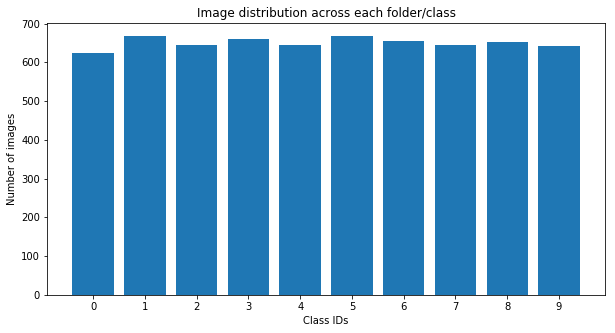

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(range(0, noOfClasses), noOfSamples)
plt.title("Image distribution across each folder/class")
x_pos = np.arange(0,10)
plt.xticks(np.arange(len(x_pos)))
plt.xlabel("Class IDs")
plt.ylabel("Number of images")
plt.show ()

## Preprocess image
### - convert to grayscale
### - equalise image
### - normalise image(0 & 1)

In [10]:
print("Before preprocessing -> ", x_train[40].shape)

Before preprocessing ->  (32, 32, 3)


In [11]:
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
#     img = img/255
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

x_train = np.array(list(map(preProcessing, x_train)))
x_test = np.array(list(map(preProcessing, x_test)))
x_validation = np.array(list(map(preProcessing, x_validation)))


print("After preprocessing -> ", x_train[40].shape)

# img = x_train[50]
# img = cv2.resize(img, (350, 350))
# cv2.imshow("preprocessed image", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

After preprocessing ->  (32, 32)


In [12]:
print("Before reshape x_train -> ", x_train.shape)
print("Before reshape x_test -> ", x_train.shape)
print("Before reshape x_validation -> ", x_train.shape)

Before reshape x_train ->  (6502, 32, 32)
Before reshape x_test ->  (6502, 32, 32)
Before reshape x_validation ->  (6502, 32, 32)


### Reshape and add a depth of 1 for the CNN

In [13]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2], 1)
x_validation = x_validation.reshape(x_validation.shape[0],x_validation.shape[1],x_validation.shape[2], 1)
print("After reshape x_train -> " , x_train.shape)
print("After reshape x_test -> " ,x_test.shape)
print("After reshape x_validation -> " ,x_validation.shape)

After reshape x_train ->  (6502, 32, 32, 1)
After reshape x_test ->  (2032, 32, 32, 1)
After reshape x_validation ->  (1626, 32, 32, 1)


# Augument image i.e. zoom, rotation, shift, translation...

In [14]:
dataGen = ImageDataGenerator(width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             zoom_range=0.2, 
                             rotation_range=10)

In [15]:
dataGen.fit(x_train)

# One hot encode

In [16]:
y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)

In [17]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5, 5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2, 2)
    noOfNode = 500
    
    model = Sequential()
    model.add((Conv2D(noOfFilters, sizeOfFilter1, input_shape=(imageDimensions[0],
                                                               imageDimensions[1],
                                                               1), activation='relu'
                                                                 )))
    
    model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu' )))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu' )))
    model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu' )))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# def myModel():
#     noOfFilters = 60
#     sizeOfFilter1 = (5,5)
#     sizeOfFilter2 = (3, 3)
#     sizeOfPool = (2,2)
#     noOfNodes= 500

#     model = Sequential()
#     model.add((Conv2D(noOfFilters,sizeOfFilter1,input_shape=(imageDimensions[0],
#                       imageDimensions[1],1),activation='relu')))
#     model.add((Conv2D(noOfFilters, sizeOfFilter1, activation='relu')))
#     model.add(MaxPooling2D(pool_size=sizeOfPool))
#     model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
#     model.add((Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu')))
#     model.add(MaxPooling2D(pool_size=sizeOfPool))
#     model.add(Dropout(0.5))

#     model.add(Flatten())
#     model.add(Dense(noOfNodes,activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(noOfClasses, activation='softmax'))

#     model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
#     return model

In [18]:
model = myModel()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [19]:
batchSizeVal = 50
epochsVal = 10
stepsPerEpochVal = 2000

# history = model.fit_generator(dataGen.flow(x_train, y_train, 
#                                  batch_size=batchSizeVal),
#                                  steps_per_epoch=stepsPerEpochVal,
#                                  epochs=epochsVal, 
#                                  validation_data=(x_validation, y_validation),
#                                  shuffle=1)

history = model.fit_generator(dataGen.flow(x_train,y_train,
                                 batch_size=batchSizeVal),
                                 steps_per_epoch=stepsPerEpochVal,
                                 epochs=epochsVal,
                                 validation_data=(x_validation,y_validation),
                                 shuffle=1)


Epoch 1/10
2000/2000 [==============================] - 933s 467ms/step - loss: 0.2761 - accuracy: 0.9082 - val_loss: 0.0292 - val_accuracy: 0.9889
Epoch 2/10
2000/2000 [==============================] - 937s 468ms/step - loss: 0.0721 - accuracy: 0.9772 - val_loss: 0.0173 - val_accuracy: 0.9951
Epoch 3/10
2000/2000 [==============================] - 707s 354ms/step - loss: 0.0526 - accuracy: 0.9833 - val_loss: 0.0188 - val_accuracy: 0.9926
Epoch 4/10
2000/2000 [==============================] - 713s 356ms/step - loss: 0.0394 - accuracy: 0.9879 - val_loss: 0.0139 - val_accuracy: 0.9945
Epoch 5/10
2000/2000 [==============================] - 693s 347ms/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0164 - val_accuracy: 0.9945
Epoch 6/10
2000/2000 [==============================] - 692s 346ms/step - loss: 0.0307 - accuracy: 0.9907 - val_loss: 0.0185 - val_accuracy: 0.9938
Epoch 7/10
2000/2000 [==============================] - 692s 346ms/step - loss: 0.0259 - accuracy: 0.9923 - val_

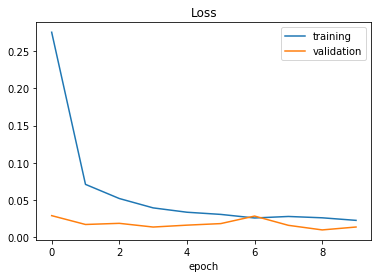

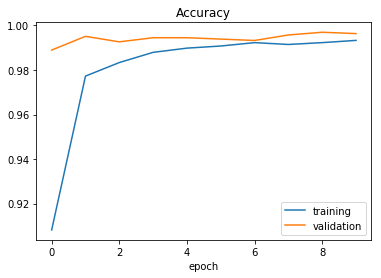

Test Score =  0.010322179518108003
Test Accuracy = 0.9955708384513855


In [23]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

#### EVALUATE USING TEST IMAGES
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

#### SAVE THE TRAINED MODEL 
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()